In [7]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

Text(0,0.5,u'$y$')

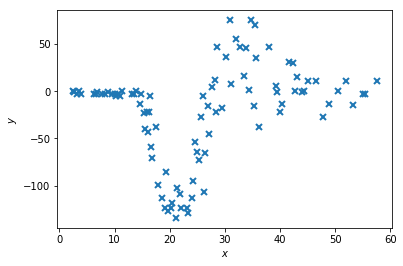

In [8]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [9]:
#build the model
k1 = hetero_kernels.RBF(1)
k2 = hetero_kernels.RBF(1)
k3 = hetero_kernels.RBF(1)
m = hetero_gpmc.GPMCAdaptive(Xnorm, Y[:,None], k1, k2, k3)

In [10]:
m

Name,values,prior,constraint
adaptive_gp.V1,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_gp.V2,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_gp.V3,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_gp.V4,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_gp.kern1.lengthscales,[ 1.],None,+ve
adaptive_gp.kern1.variance,[ 1.],None,+ve
adaptive_gp.kern2.lengthscales,[ 1.],None,+ve
adaptive_gp.kern2.variance,[ 1.],None,+ve
adaptive_gp.kern3.lengthscales,[ 1.],None,+ve
adaptive_gp.kern3.variance,[ 1.],None,+ve


In [11]:
#m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.kern1.variance.prior = gpflow.priors.Gamma(1.,1.)

#m.kern2.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.kern2.variance.prior = gpflow.priors.Gamma(1.,1.)

#m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern1.lengthscales = 1
m.kern1.lengthscales.fixed = True
m.kern1.variance = 1.
m.kern1.variance.fixed = True

#m.kern2.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern2.lengthscales = 1
m.kern2.lengthscales.fixed = True
m.kern2.variance = 40.
m.kern2.variance.fixed = True
#m.kern1.variance.prior = gpflow.priors.Gamma(1., 1.)

#m.kern3.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.kern3.variance.prior = gpflow.priors.Gamma(1., 1.)
m.kern3.variance = 100.
m.kern3.variance.fixed = True

In [12]:
m.optimize(maxiter=5000) # start near MAP

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: adaptive_gp.build_likelihood_1/Cholesky_3 = Cholesky[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"](adaptive_gp.build_likelihood_1/add_4)]]

Caused by op u'adaptive_gp.build_likelihood_1/Cholesky_3', defined at:
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2828, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-ea490ca2448d>", line 1, in <module>
    m.optimize(maxiter=5000) # start near MAP
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/gpflow-0.4.0-py2.7.egg/gpflow/model.py", line 250, in optimize
    return self._optimize_np(method, tol, callback, maxiter, **kw)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/gpflow-0.4.0-py2.7.egg/gpflow/model.py", line 311, in _optimize_np
    self.compile()
  File "../GPHetero/hetero_gpmc.py", line 270, in compile
    optimizer=optimizer)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/gpflow-0.4.0-py2.7.egg/gpflow/model.py", line 156, in compile
    f = self.build_likelihood() + self.build_prior()
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/gpflow-0.4.0-py2.7.egg/gpflow/scoping.py", line 43, in runnable
    return f(*args, **kwargs)
  File "../GPHetero/hetero_gpmc.py", line 302, in build_likelihood
    F = tf.matmul(Lnonstat, self.V4)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 704, in cholesky
    "Cholesky", input=input, name=name)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: adaptive_gp.build_likelihood_1/Cholesky_3 = Cholesky[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"](adaptive_gp.build_likelihood_1/add_4)]]


In [ ]:
m

In [ ]:
samples = m.sample(1000, verbose=True, epsilon=0.05, thin = 2, burn = 500, Lmax = 40)

In [ ]:
m